# Tech Team Ticket Metrics

## Retrieve Current Data

In [1]:
# SPDX-License-Identifier: Apache-2.0
# Licensed to the Ed-Fi Alliance under one or more agreements.
# The Ed-Fi Alliance licenses this file to you under the Apache License, Version 2.0.
# See the LICENSE and NOTICES files in the project root for more information.

from edfi_tech_metrics.settings import load_from_env, Configuration
from edfi_tech_metrics.jira import JiraBrowser
from edfi_tech_metrics.ticket_age import write_ticket_age_files, generate_ticket_age_plots
from edfi_tech_metrics.disable_tls import no_tls_verification

conf: Configuration = load_from_env()
#conf.log_level = "DEBUG"

with no_tls_verification():
    browser = JiraBrowser(conf)

portfolios = {
    "ODS Platform": ["ODS", "PERF"],
    "Team B": ["METAED", "DMS", "ADMINAPI"],
    "Ed-Fi Tools": ["AA", "AC", "APIPUB", "DI", "EPPETA"],
    "Data Standard": [ "DATASTD", "MODL", "TPDMDEV"],
    "Support": ["EDFI"]
}

projects = [i for _, v in portfolios.items() for i in v]
with no_tls_verification():
    df = browser.get_unresolved_tickets(projects)

Connecting to https://edfi.atlassian.net
Retrieving tickets for ODS
Retrieving tickets for PERF
Retrieving tickets for METAED
Retrieving tickets for DMS
Retrieving tickets for ADMINAPI
Retrieving tickets for AA
Retrieving tickets for AC
Retrieving tickets for APIPUB
Retrieving tickets for DI
Retrieving tickets for EPPETA
Retrieving tickets for DATASTD
Retrieving tickets for MODL
Retrieving tickets for TPDMDEV
Retrieving tickets for EDFI


In [2]:
write_ticket_age_files(conf, df)

Writing age data out to file: ./data/ticket-age/2024-11-12.csv
Writing age data out to file: ./data/ticket-age-filtered/2024-11-12.csv


### Filtered Tickets

These plots exclude "Test" type tickets and those that have an assigned Fix Version.

2024-11-12 19:29:27,289 - INFO - matplotlib.font_manager - generated new fontManager


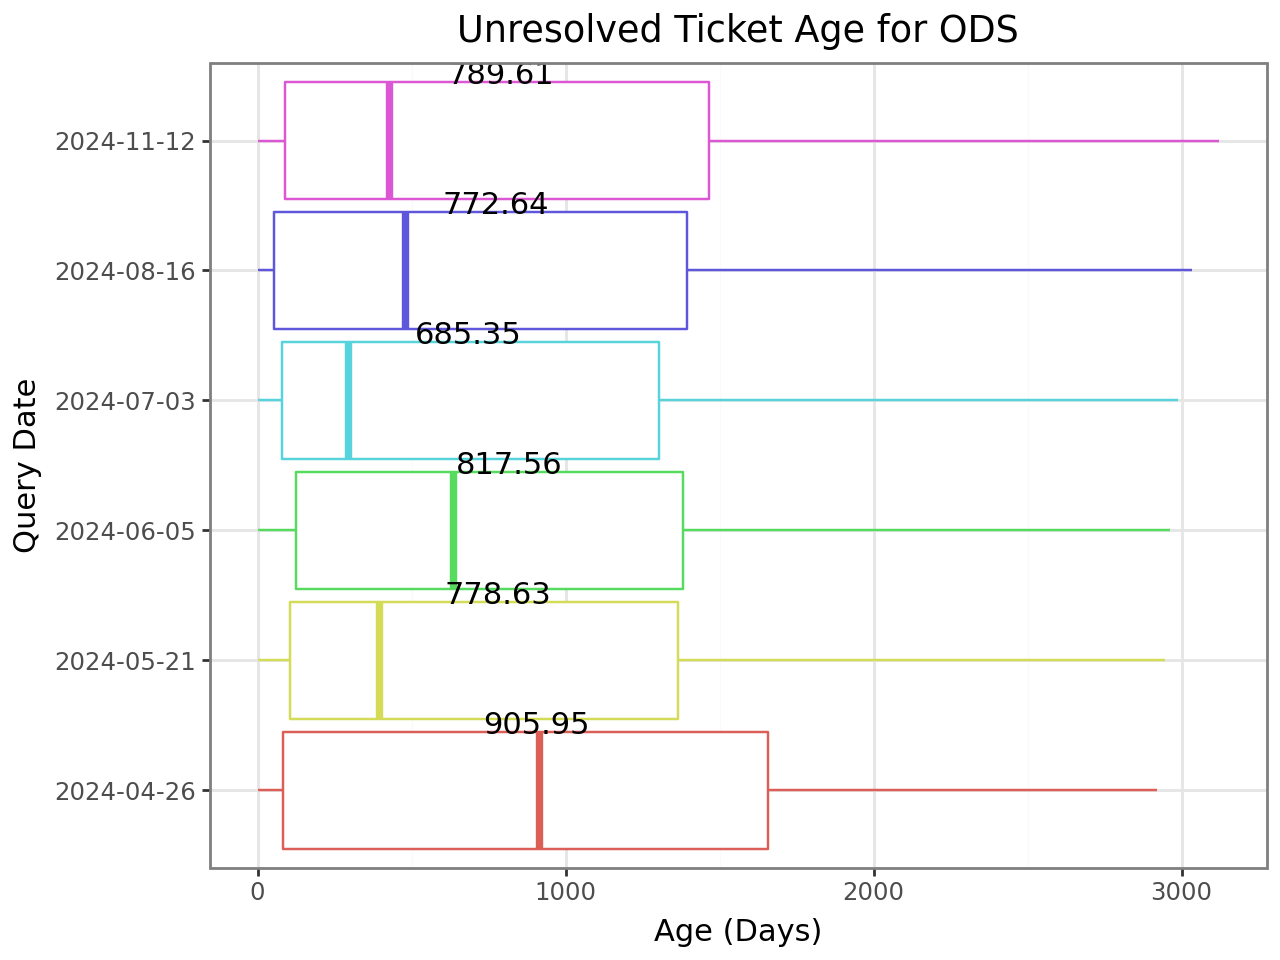

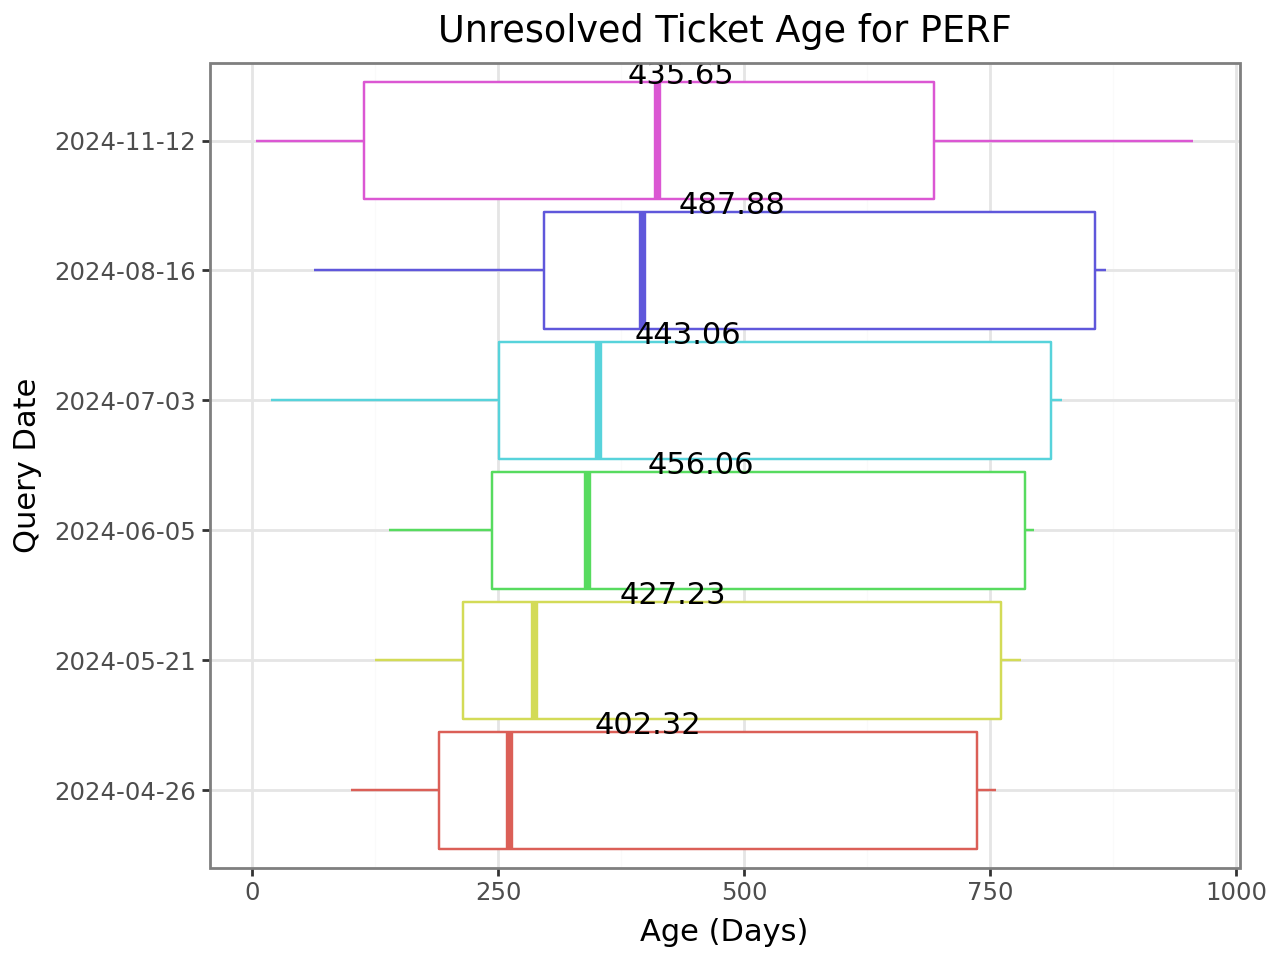

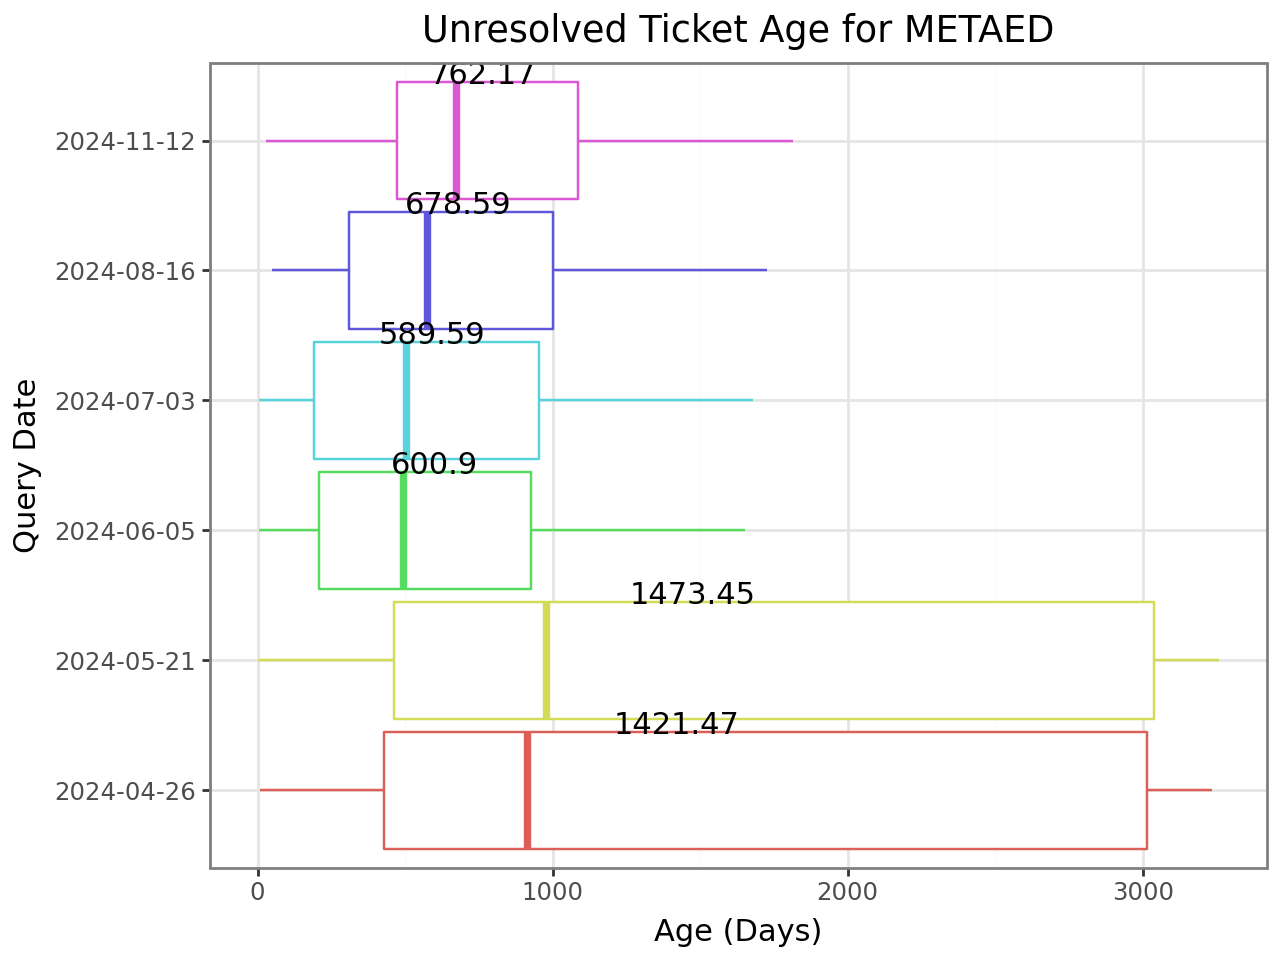

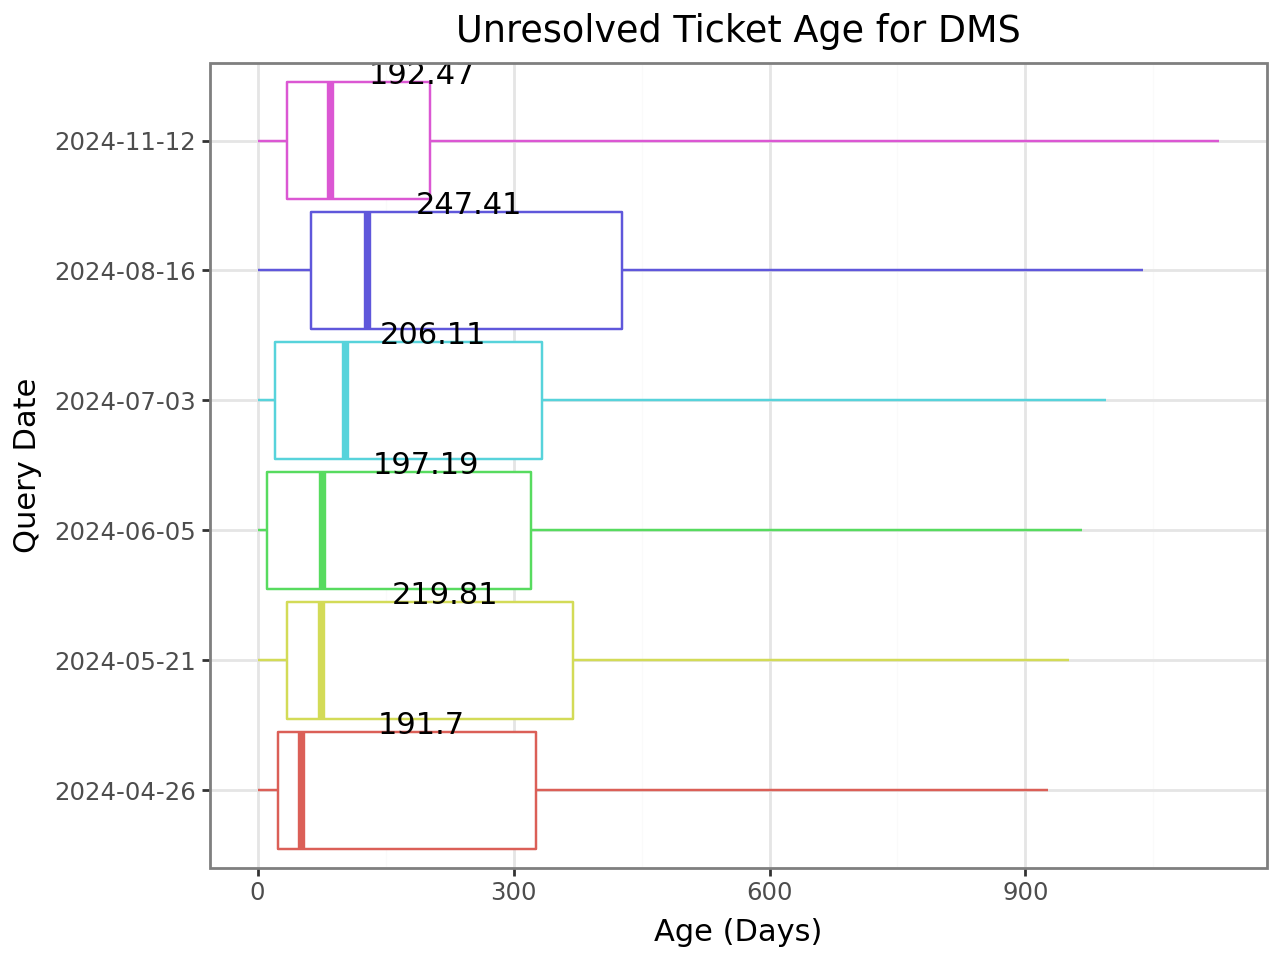

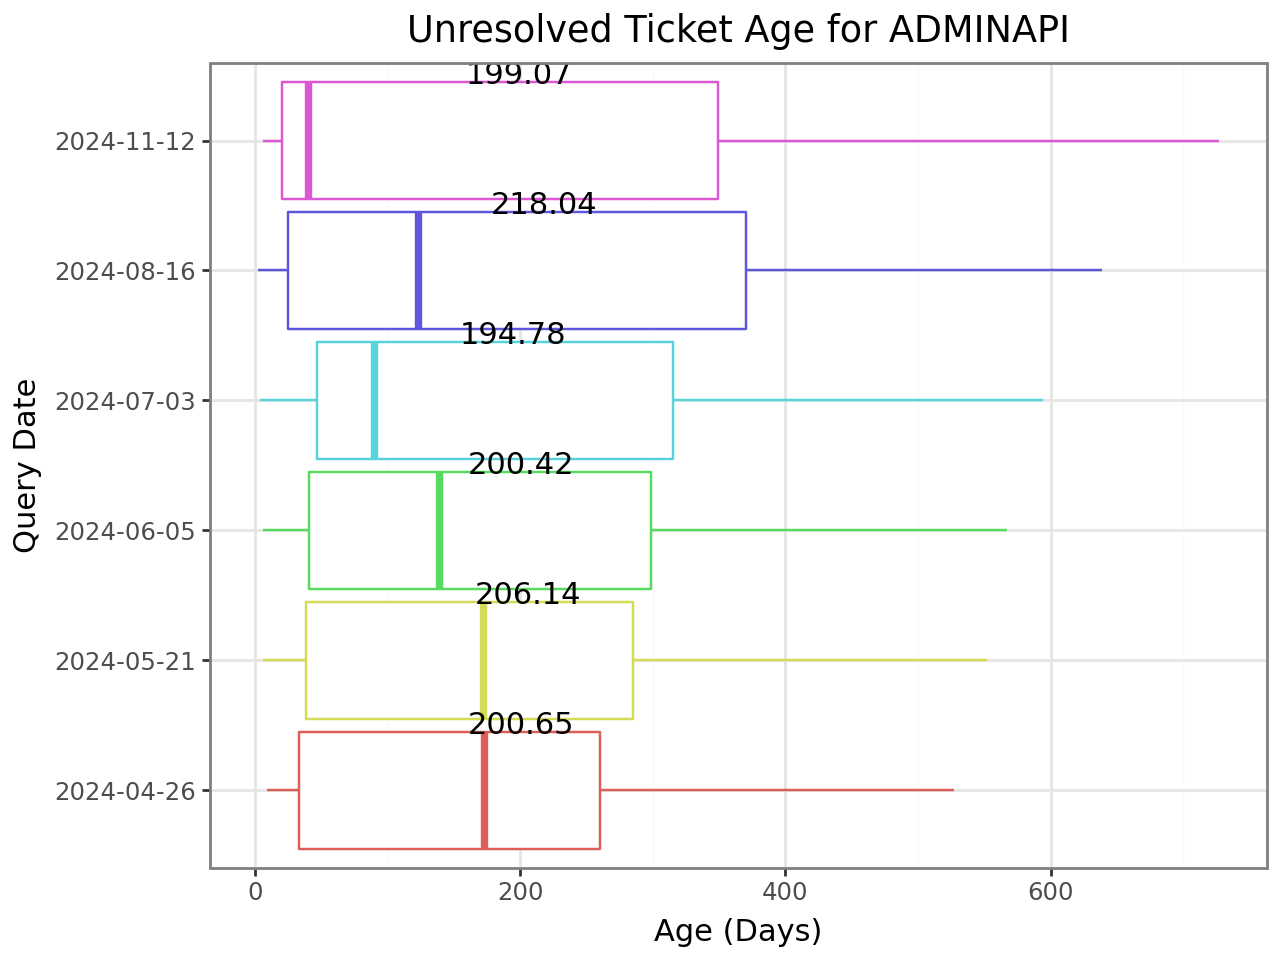

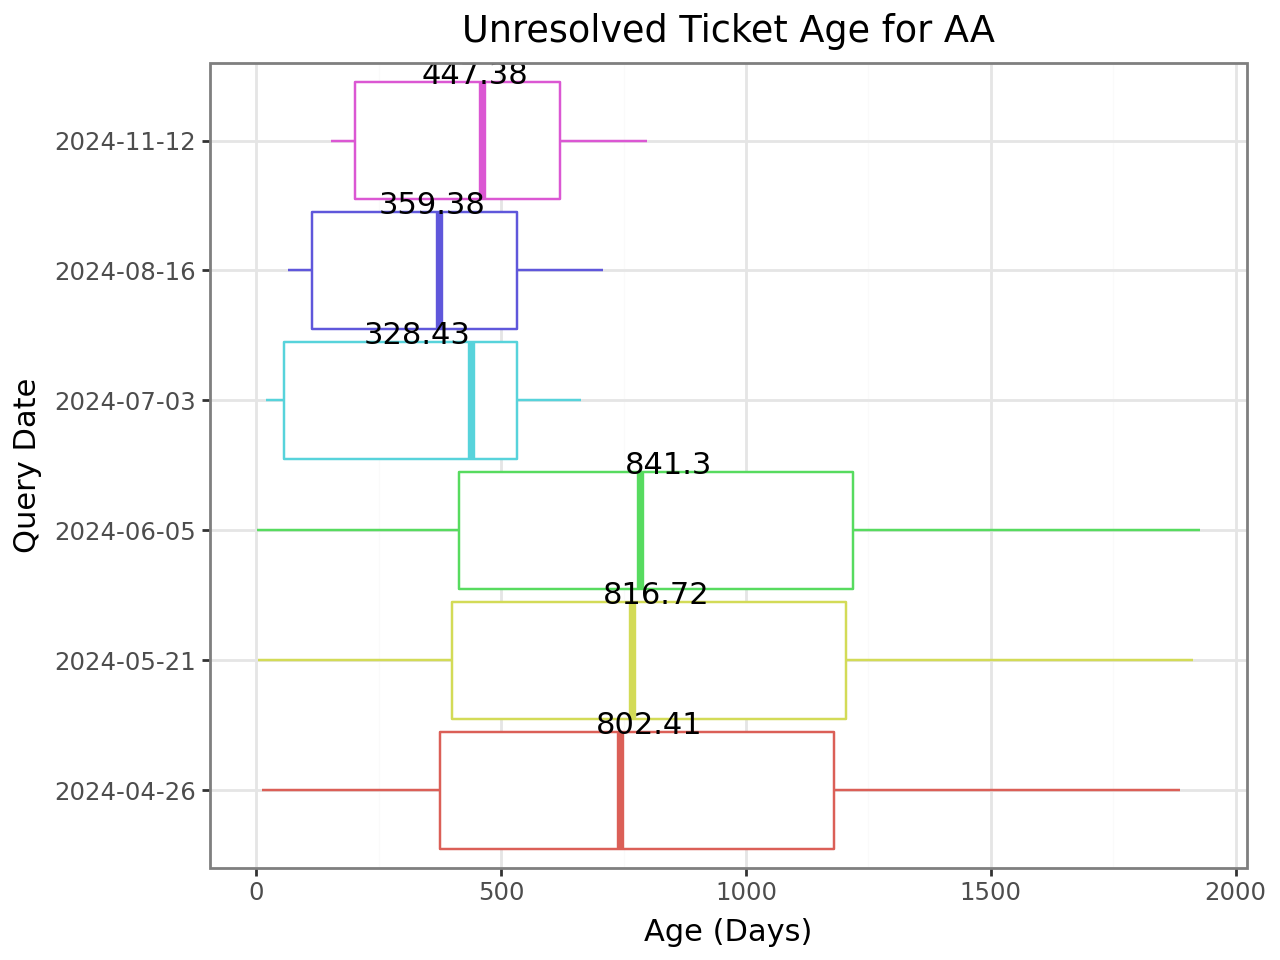

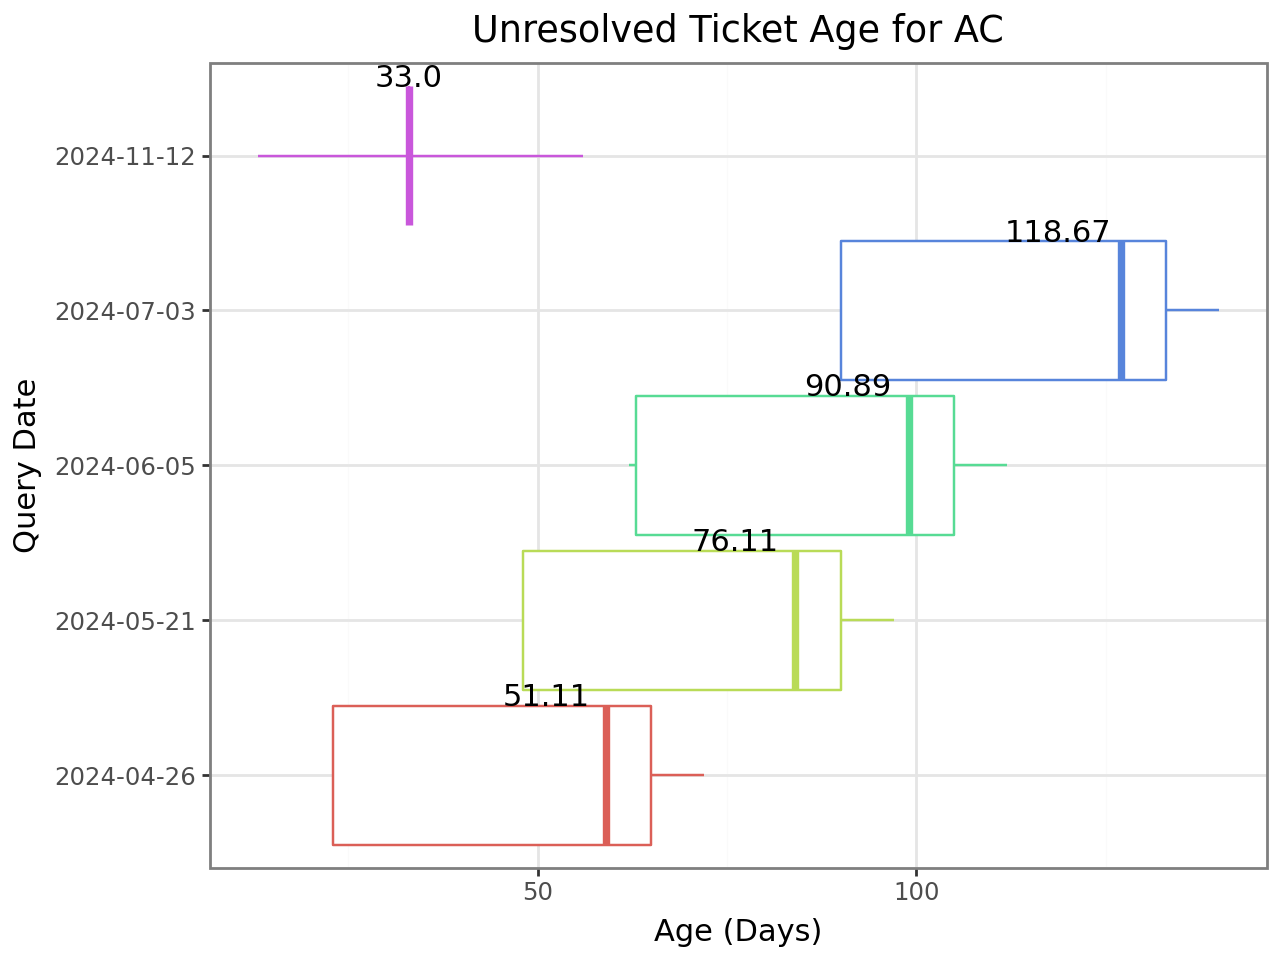

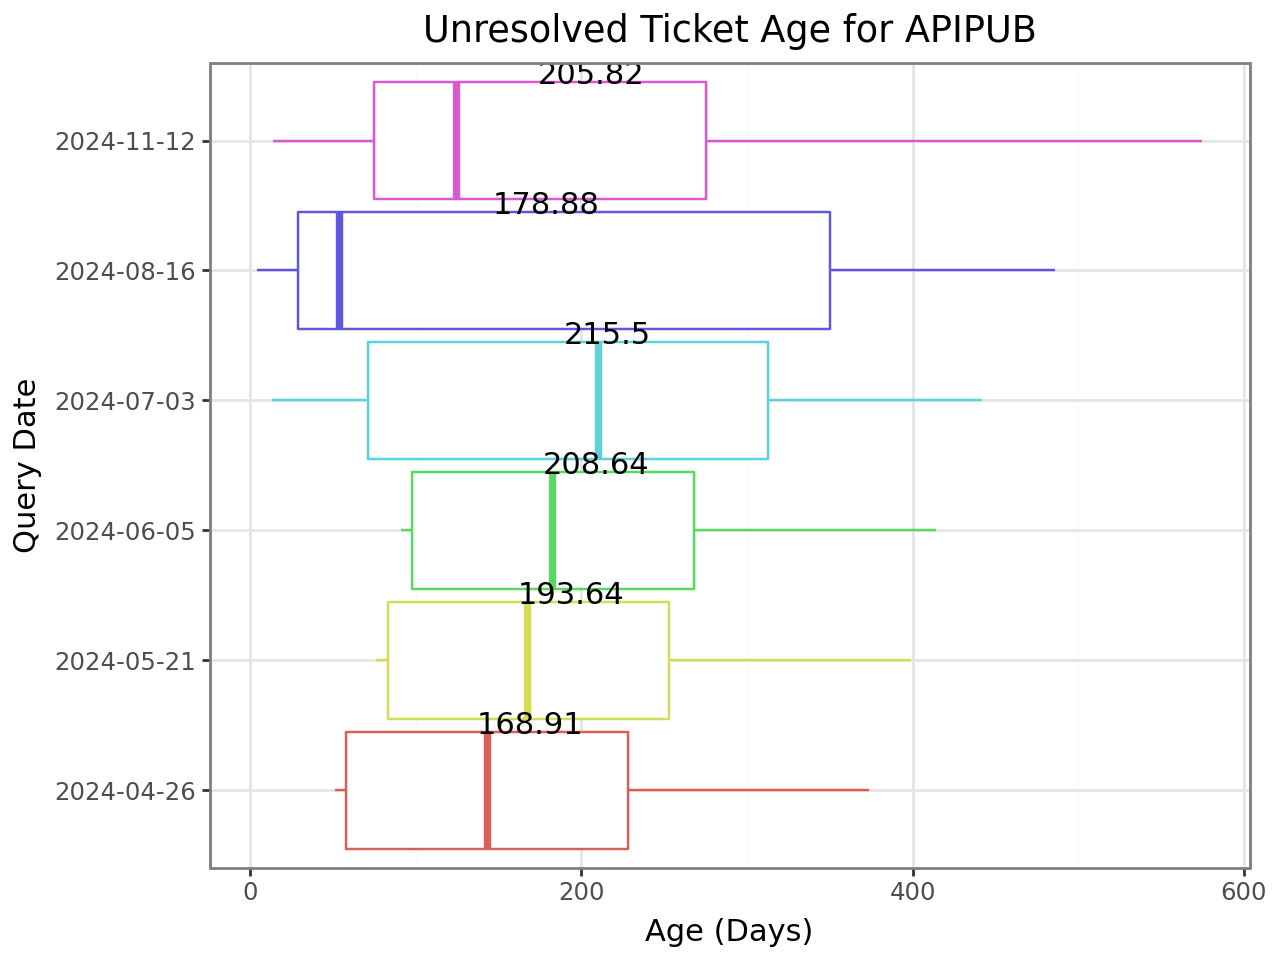

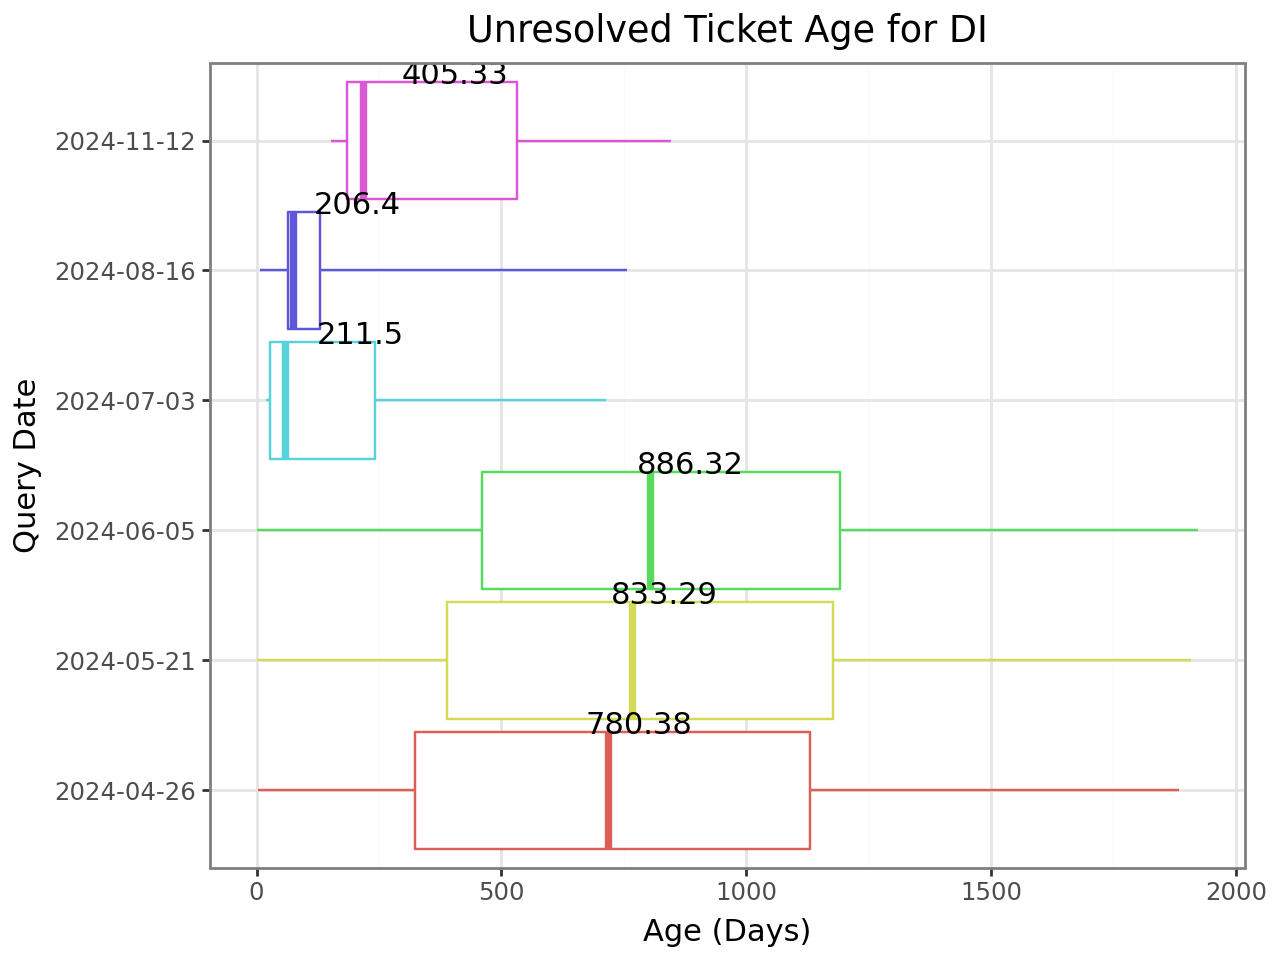

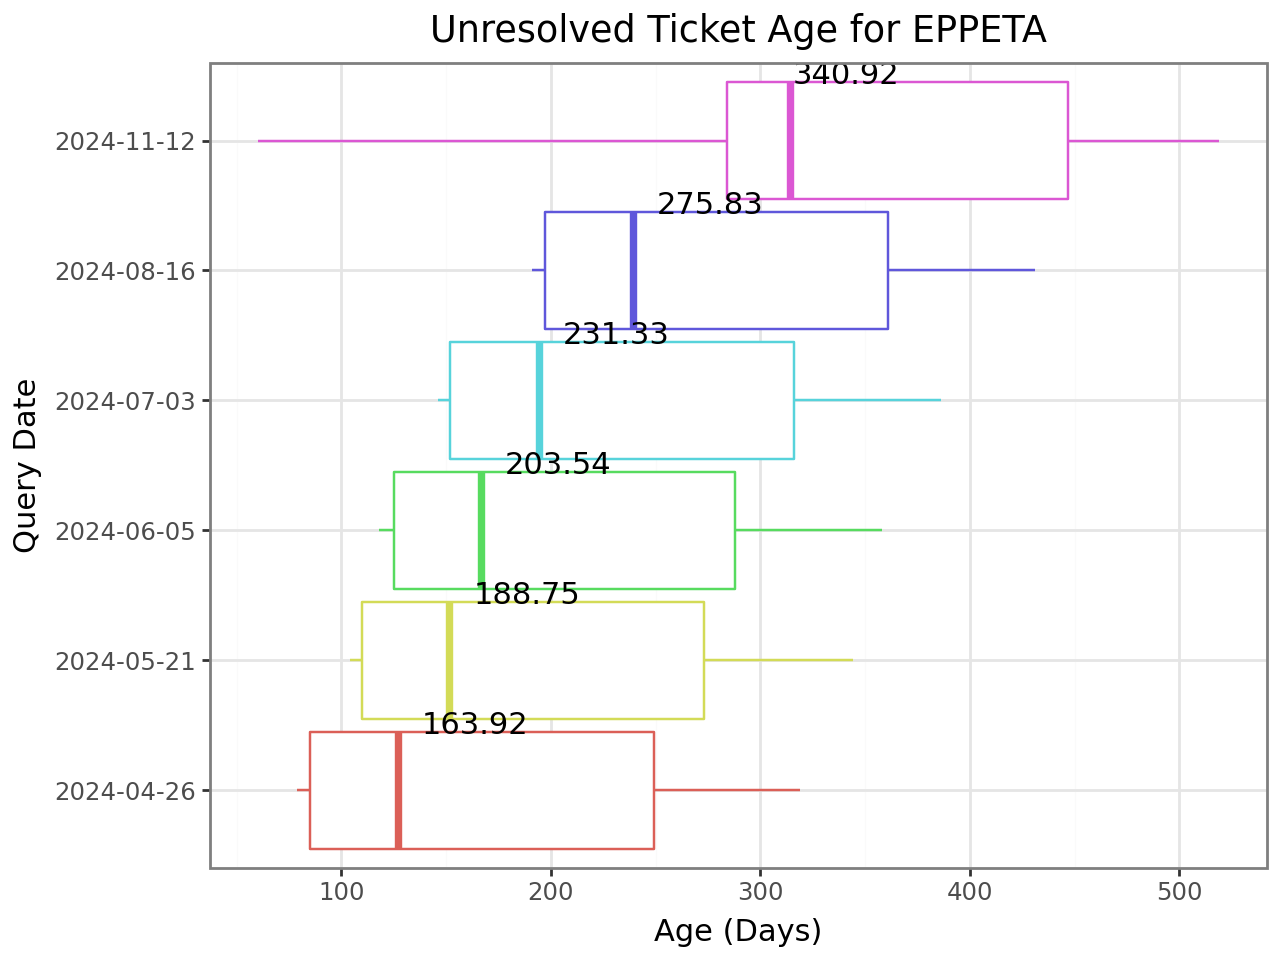

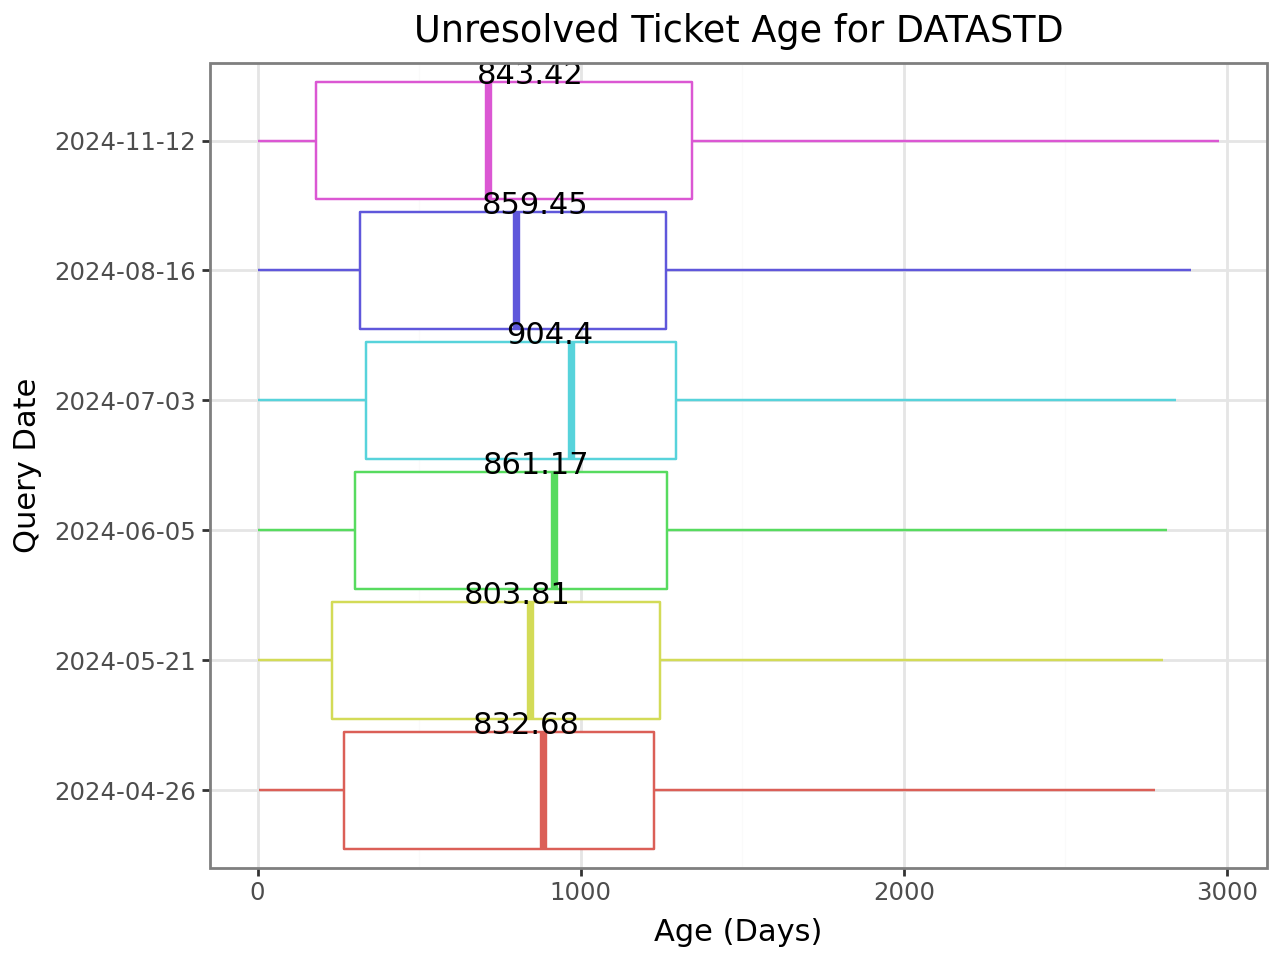

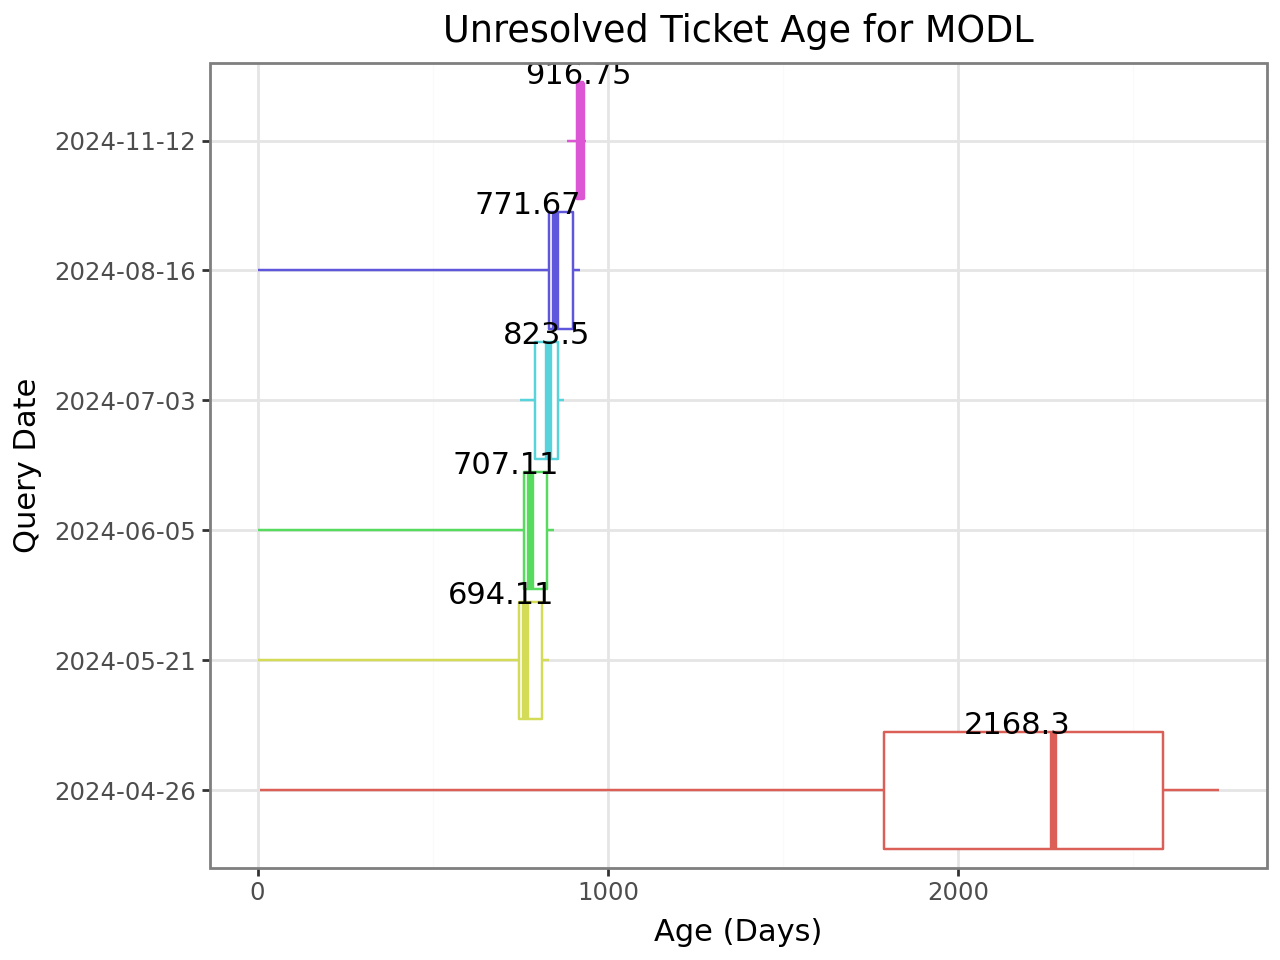

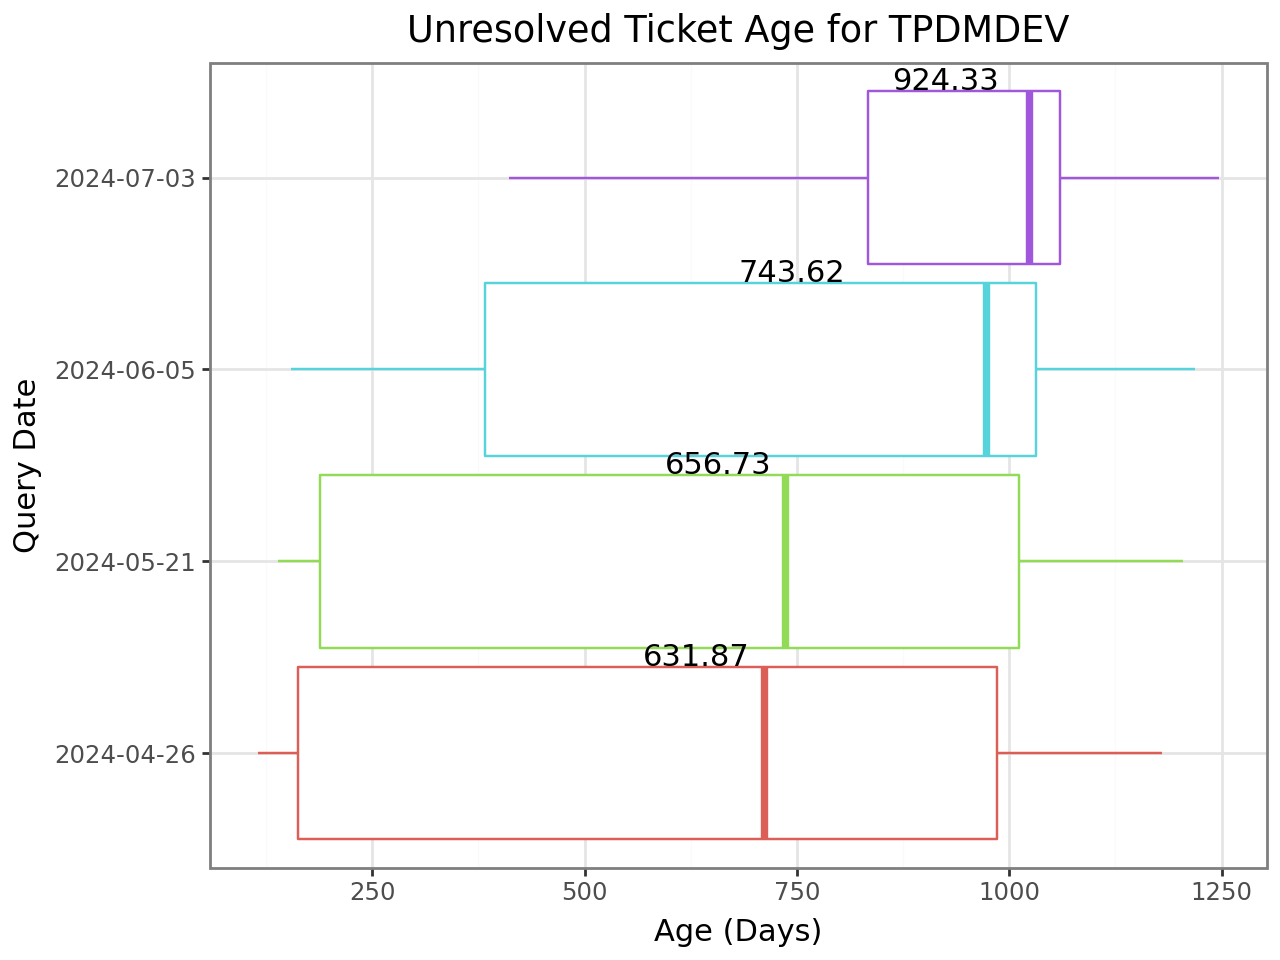

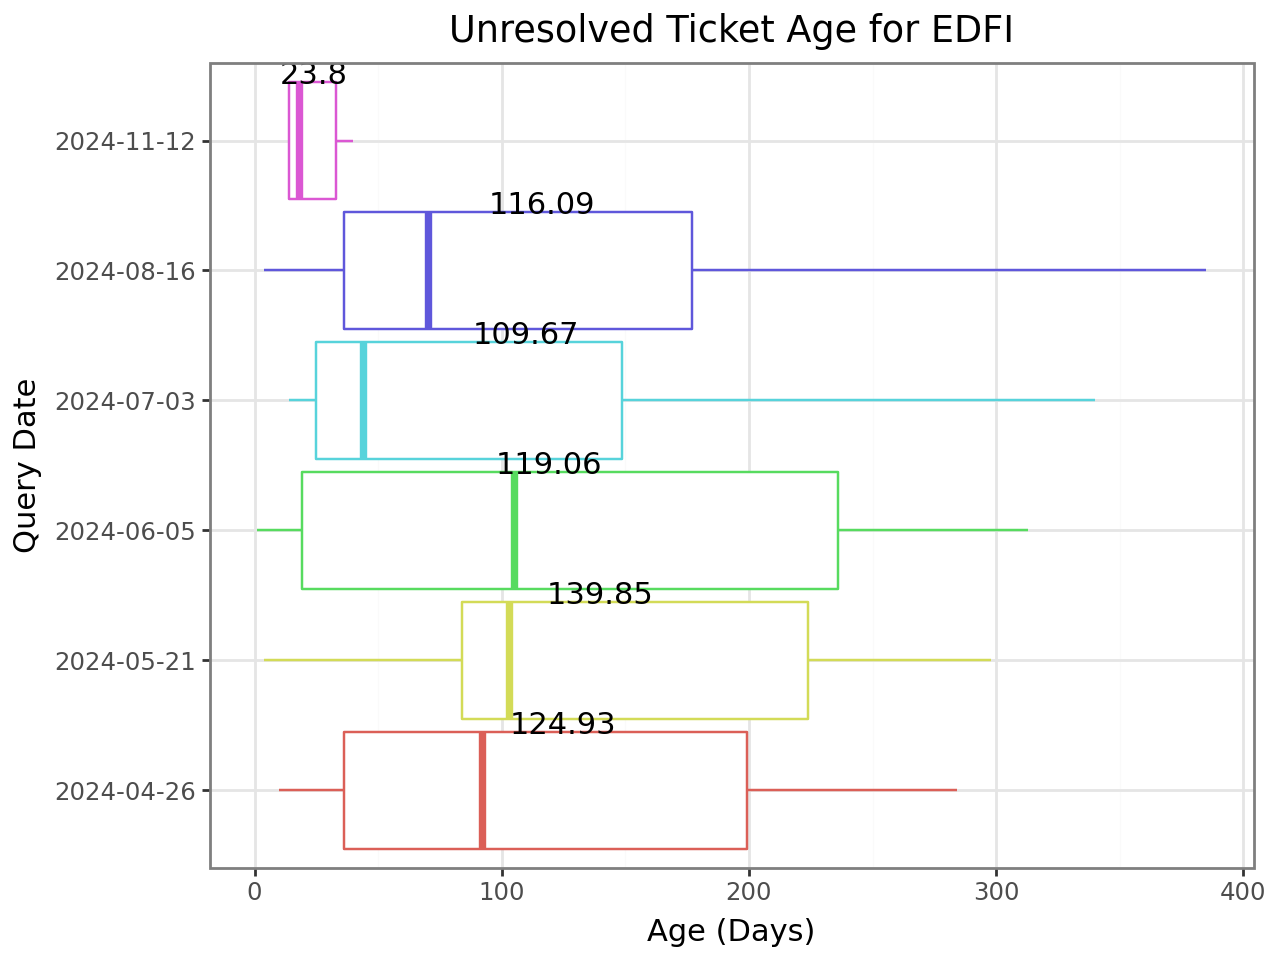

In [3]:
generate_ticket_age_plots("./data/ticket-age-filtered", projects)

## Improvements

Comparing latest to first measurement for each project

In [4]:
base_dir = "./data/ticket-age-filtered"
from edfi_tech_metrics.improvements import calculate_improvements

delta_df = calculate_improvements(base_dir, projects)
display(delta_df)
delta_df.describe()

,project,original,current,delta
0,AA,802.412500,447.375000,0.442463
1,AC,51.111111,33.000000,0.354348
2,ADMINAPI,200.653846,199.074074,0.007873
3,APIPUB,168.909091,205.818182,-0.218515
4,DATASTD,832.679245,843.424837,-0.012905
5,DI,780.382609,405.333333,0.480597
6,DMS,191.703704,192.465347,-0.003973
7,EDFI,124.931034,23.800000,0.809495
8,EPPETA,163.916667,340.923077,-1.079856
9,METAED,1421.466019,762.169811,0.463814


,original,current,delta
count,13.000000,13.000000,13.000000
mean,631.902490,430.415265,0.143546
std,619.854413,308.084517,0.476571
min,51.111111,23.800000,-1.079856
25%,168.909091,199.074074,-0.012905
50%,402.318182,405.333333,0.128412
75%,832.679245,762.169811,0.463814
max,2168.300781,916.750000,0.809495


## Backlog Health

Enter current team average velocity over the last five sprints below:

In [7]:
from edfi_tech_metrics.backlog import run_backlog_health_ui
run_backlog_health_ui(df, portfolios)

interactive(children=(Text(value='1.0', continuous_update=False, description='data_standard'), Text(value='1.0…